In [1]:
## Reading libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
import warnings
from sklearn import metrics
from sklearn.metrics import mean_squared_error,log_loss
from sklearn.model_selection import KFold,StratifiedKFold,GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import lightgbm as lgb
from xgboost import XGBRegressor
import requests
from io import StringIO
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from catboost import CatBoostRegressor, CatBoostClassifier

warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('max_column', 100)

In [2]:
def negative(x):
    if x < 0.0:
        return 0
    else:
        return x

In [3]:
sample_sub = pd.read_csv('SampleSubmission.csv')
train = pd.read_csv('Train.csv')

In [4]:
train.head(2)

,X,Y,target_2015,elevation,precip 2014-11-16 - 2014-11-23,precip 2014-11-23 - 2014-11-30,precip 2014-11-30 - 2014-12-07,precip 2014-12-07 - 2014-12-14,precip 2014-12-14 - 2014-12-21,precip 2014-12-21 - 2014-12-28,precip 2014-12-28 - 2015-01-04,precip 2015-01-04 - 2015-01-11,precip 2015-01-11 - 2015-01-18,precip 2015-01-18 - 2015-01-25,precip 2015-01-25 - 2015-02-01,precip 2015-02-01 - 2015-02-08,precip 2015-02-08 - 2015-02-15,precip 2015-02-15 - 2015-02-22,precip 2015-02-22 - 2015-03-01,precip 2015-03-01 - 2015-03-08,precip 2015-03-08 - 2015-03-15,precip 2019-01-20 - 2019-01-27,precip 2019-01-27 - 2019-02-03,precip 2019-02-03 - 2019-02-10,precip 2019-02-10 - 2019-02-17,precip 2019-02-17 - 2019-02-24,precip 2019-02-24 - 2019-03-03,precip 2019-03-03 - 2019-03-10,precip 2019-03-10 - 2019-03-17,precip 2019-03-17 - 2019-03-24,precip 2019-03-24 - 2019-03-31,precip 2019-03-31 - 2019-04-07,precip 2019-04-07 - 2019-04-14,precip 2019-04-14 - 2019-04-21,precip 2019-04-21 - 2019-04-28,precip 2019-04-28 - 2019-05-05,precip 2019-05-05 - 2019-05-12,precip 2019-05-12 - 2019-05-19,LC_Type1_mode,Square_ID
0,34.26,-15.91,0.0,887.764222,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,29.389995,32.878318,8.179804,0.963981,16.659097,3.304466,0.0,12.99262,4.582856,35.037532,4.796012,28.083314,0.0,58.362456,18.264692,17.537486,0.896323,1.68,0.0,0.0,0.0,0.0,0.0,0.0,9,4e3c3896-14ce-11ea-bce5-f49634744a41
1,34.26,-15.90,0.0,743.403912,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,29.389995,32.878318,8.179804,0.963981,16.659097,3.304466,0.0,12.99262,4.582856,35.037532,4.796012,28.083314,0.0,58.362456,18.264692,17.537486,0.896323,1.68,0.0,0.0,0.0,0.0,0.0,0.0,9,4e3c3897-14ce-11ea-bce5-f49634744a41


In [5]:
# Creating lists of columns to be used in separating the dataframe into training and testing datasets
# Using a for loop for efficiency
#
precip_features_2019 = []
precip_features_2015 = []
for col in train.columns:
  if '2019' in col:
    precip_features_2019.append(col)
  elif 'precip 2014' in col:
    precip_features_2015.append(col)
  elif 'precip 2015' in col:
    precip_features_2015.append(col)
new_train = train[train.columns.difference(precip_features_2019)]
# Separating the test dataset from the main dataframe
precip_features_2019.extend(['X', 'Y', 'elevation', 'LC_Type1_mode', 'Square_ID'])
test = train[precip_features_2019]
# Creating a dictionary of column names to be renamed for the training dataset
# The column names are renamed for conveniency
#
new_2015_cols = {}
for col, number in zip(precip_features_2015, range(1, len(precip_features_2015) + 1)):
  if 'precip' in col:
    new_2015_cols[col] = 'week_' + str(number) + '_precip'

    
# Creating a dictionary of column names to be renamed for the testing dataset
#
new_2019_cols = {}
for col, number in zip(precip_features_2019, range(1, len(precip_features_2019) + 1)):
  if 'precip' in col:
    new_2019_cols[col] = 'week_' + str(number) + '_precip'
    
# Renaming the columns
#
new_train.rename(columns = new_2015_cols, inplace = True)
test.rename(columns = new_2019_cols, inplace = True)
# Separating the target variable
#
target = new_train.target_2015


# Aligning the training and testing datasets
#
new_train, test = new_train.align(test, join = 'inner', axis = 1)
test_id = sample_sub['Square_ID']
y = target
new_train.drop(columns='Square_ID', inplace=True)
test.drop(columns='Square_ID', inplace=True)
X = new_train

In [6]:
X_len = len(X)
new_df = pd.concat([X, test])

In [7]:
#Manhattan distnace
def manhattan_distance(lat, lon):
    a = np.abs(lat -lon)
    return a
new_df['manhattan_dist'] = manhattan_distance(new_df['X'].values, new_df['Y'].values,)
new_df.head()

#Bearing
def bearing_array(lat, lng):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lat - lng)
    lat, lng = map(np.radians, (lat, lng))
    y = np.sin(lng_delta_rad) * np.cos(lat)
    x = np.cos(lat) * np.sin(lat) - np.sin(lng) * np.cos(lng) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))
new_df['bearing'] = bearing_array(new_df['X'].values, new_df['Y'].values,)
new_df.head()
corr_matrix = new_df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] >= 0.8)]
print('There are {} columns with >= 0.8 correlation'.format(len(to_drop)))
to_drop

There are 7 columns with >= 0.8 correlation


['week_3_precip',
 'week_7_precip',
 'week_11_precip',
 'week_12_precip',
 'week_15_precip',
 'week_17_precip',
 'bearing']

In [8]:
new_df.drop(to_drop, axis=1, inplace=True)

In [9]:
train = new_df[:X_len]
test = new_df[X_len:]

In [10]:
train['target_2015'] = y

In [12]:
train['target_2015'].value_counts()

0.000000    13701
1.000000      385
0.129089        5
0.032284        5
0.983864        5
            ...  
0.535626        1
0.301399        1
0.384718        1
0.570683        1
0.137383        1
Name: target_2015, Length: 2319, dtype: int64

In [13]:
train['week_1_2_precip'] = train['week_2_precip'] / train['week_1_precip']
test['week_1_2_precip'] = test['week_2_precip'] / test['week_1_precip']

train['week_9_14_precip'] = train['week_9_precip'] * train['week_14_precip']
test['week_9_14_precip'] = test['week_9_precip'] * test['week_14_precip']

train.manhattan_dist = train.manhattan_dist  - train.Y
test.manhattan_dist = test.manhattan_dist  - train.Y

In [14]:
def target(x):
    if x >= 0.5:
        return 1
    else:
        return 0

train['target_2015'] = train['target_2015'].map(target)

In [15]:
train['target_2015'].value_counts()

0    15312
1     1154
Name: target_2015, dtype: int64

In [16]:
train['elevation'] = np.log(train['elevation'])
test['elevation'] = np.log(test['elevation'])

train['X'] = np.log(train['X'])
test['X'] = np.log(test['X'])

In [17]:
X = train.drop(columns='target_2015')
y = train['target_2015']

In [19]:
x_fold = X[:12006]
y_fold = y[:12006]

In [20]:
categorical_features_indices = np.where(X.dtypes != np.float)[0]; categorical_features_indices

array([0])

## MODEL

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_fold, y_fold, test_size=0.2, random_state=1994)

In [22]:
model = CatBoostClassifier(learning_rate=0.09, depth=3, n_estimators=10000)#0.09
model.fit(X_train, y_train)

0:	learn: 0.5185054	total: 118ms	remaining: 19m 34s
1:	learn: 0.3949443	total: 123ms	remaining: 10m 15s
2:	learn: 0.3204216	total: 128ms	remaining: 7m 5s
3:	learn: 0.2574289	total: 132ms	remaining: 5m 30s
4:	learn: 0.2219989	total: 138ms	remaining: 4m 36s
5:	learn: 0.1913957	total: 143ms	remaining: 3m 58s
6:	learn: 0.1689416	total: 148ms	remaining: 3m 31s
7:	learn: 0.1486324	total: 152ms	remaining: 3m 10s
8:	learn: 0.1323024	total: 157ms	remaining: 2m 54s
9:	learn: 0.1227708	total: 162ms	remaining: 2m 41s
10:	learn: 0.1132564	total: 166ms	remaining: 2m 31s
11:	learn: 0.1062290	total: 171ms	remaining: 2m 22s
12:	learn: 0.1003987	total: 175ms	remaining: 2m 14s
13:	learn: 0.0967049	total: 180ms	remaining: 2m 8s
14:	learn: 0.0938266	total: 184ms	remaining: 2m 2s
15:	learn: 0.0903448	total: 189ms	remaining: 1m 57s
16:	learn: 0.0882672	total: 194ms	remaining: 1m 53s
17:	learn: 0.0855287	total: 198ms	remaining: 1m 49s
18:	learn: 0.0838811	total: 202ms	remaining: 1m 46s
19:	learn: 0.0828667	to

182:	learn: 0.0468359	total: 1.1s	remaining: 59.1s
183:	learn: 0.0467868	total: 1.11s	remaining: 59.1s
184:	learn: 0.0467383	total: 1.11s	remaining: 59.1s
185:	learn: 0.0466276	total: 1.12s	remaining: 59.1s
186:	learn: 0.0465206	total: 1.13s	remaining: 59.1s
187:	learn: 0.0464427	total: 1.14s	remaining: 59.2s
188:	learn: 0.0463908	total: 1.14s	remaining: 59.3s
189:	learn: 0.0463224	total: 1.15s	remaining: 59.4s
190:	learn: 0.0461879	total: 1.16s	remaining: 59.4s
191:	learn: 0.0461668	total: 1.16s	remaining: 59.3s
192:	learn: 0.0460358	total: 1.17s	remaining: 59.4s
193:	learn: 0.0459253	total: 1.17s	remaining: 59.3s
194:	learn: 0.0459138	total: 1.18s	remaining: 59.2s
195:	learn: 0.0458488	total: 1.18s	remaining: 59.1s
196:	learn: 0.0457734	total: 1.19s	remaining: 59.1s
197:	learn: 0.0457087	total: 1.19s	remaining: 59s
198:	learn: 0.0456722	total: 1.2s	remaining: 58.9s
199:	learn: 0.0456522	total: 1.2s	remaining: 58.8s
200:	learn: 0.0455608	total: 1.21s	remaining: 58.8s
201:	learn: 0.045

376:	learn: 0.0375879	total: 2.08s	remaining: 53s
377:	learn: 0.0375492	total: 2.08s	remaining: 53s
378:	learn: 0.0375371	total: 2.09s	remaining: 53.1s
379:	learn: 0.0375007	total: 2.1s	remaining: 53.1s
380:	learn: 0.0374625	total: 2.1s	remaining: 53.2s
381:	learn: 0.0374192	total: 2.11s	remaining: 53.2s
382:	learn: 0.0374045	total: 2.12s	remaining: 53.2s
383:	learn: 0.0373724	total: 2.12s	remaining: 53.2s
384:	learn: 0.0373016	total: 2.13s	remaining: 53.1s
385:	learn: 0.0372707	total: 2.14s	remaining: 53.2s
386:	learn: 0.0372197	total: 2.14s	remaining: 53.2s
387:	learn: 0.0371859	total: 2.15s	remaining: 53.2s
388:	learn: 0.0371435	total: 2.15s	remaining: 53.1s
389:	learn: 0.0370408	total: 2.15s	remaining: 53.1s
390:	learn: 0.0370177	total: 2.16s	remaining: 53.1s
391:	learn: 0.0369782	total: 2.17s	remaining: 53.1s
392:	learn: 0.0369054	total: 2.17s	remaining: 53s
393:	learn: 0.0368850	total: 2.17s	remaining: 53s
394:	learn: 0.0368551	total: 2.18s	remaining: 53s
395:	learn: 0.0368269	to

543:	learn: 0.0324872	total: 3.08s	remaining: 53.5s
544:	learn: 0.0324308	total: 3.09s	remaining: 53.5s
545:	learn: 0.0324184	total: 3.09s	remaining: 53.5s
546:	learn: 0.0323941	total: 3.1s	remaining: 53.5s
547:	learn: 0.0323254	total: 3.1s	remaining: 53.5s
548:	learn: 0.0322962	total: 3.11s	remaining: 53.6s
549:	learn: 0.0322803	total: 3.12s	remaining: 53.5s
550:	learn: 0.0322615	total: 3.12s	remaining: 53.6s
551:	learn: 0.0322379	total: 3.13s	remaining: 53.5s
552:	learn: 0.0322140	total: 3.13s	remaining: 53.5s
553:	learn: 0.0322085	total: 3.14s	remaining: 53.5s
554:	learn: 0.0321950	total: 3.14s	remaining: 53.5s
555:	learn: 0.0321863	total: 3.15s	remaining: 53.5s
556:	learn: 0.0321462	total: 3.15s	remaining: 53.4s
557:	learn: 0.0321287	total: 3.16s	remaining: 53.4s
558:	learn: 0.0320851	total: 3.17s	remaining: 53.5s
559:	learn: 0.0320640	total: 3.17s	remaining: 53.5s
560:	learn: 0.0320409	total: 3.18s	remaining: 53.5s
561:	learn: 0.0320170	total: 3.19s	remaining: 53.5s
562:	learn: 0.

718:	learn: 0.0287066	total: 4.27s	remaining: 55.1s
719:	learn: 0.0286777	total: 4.28s	remaining: 55.1s
720:	learn: 0.0286748	total: 4.29s	remaining: 55.2s
721:	learn: 0.0286190	total: 4.3s	remaining: 55.2s
722:	learn: 0.0285850	total: 4.3s	remaining: 55.2s
723:	learn: 0.0285205	total: 4.31s	remaining: 55.2s
724:	learn: 0.0285060	total: 4.32s	remaining: 55.3s
725:	learn: 0.0284584	total: 4.33s	remaining: 55.3s
726:	learn: 0.0284396	total: 4.34s	remaining: 55.3s
727:	learn: 0.0284153	total: 4.34s	remaining: 55.3s
728:	learn: 0.0284091	total: 4.36s	remaining: 55.4s
729:	learn: 0.0283652	total: 4.37s	remaining: 55.5s
730:	learn: 0.0283598	total: 4.38s	remaining: 55.5s
731:	learn: 0.0283090	total: 4.39s	remaining: 55.5s
732:	learn: 0.0282886	total: 4.4s	remaining: 55.6s
733:	learn: 0.0282758	total: 4.4s	remaining: 55.6s
734:	learn: 0.0282446	total: 4.41s	remaining: 55.5s
735:	learn: 0.0282213	total: 4.41s	remaining: 55.5s
736:	learn: 0.0282080	total: 4.42s	remaining: 55.5s
737:	learn: 0.02

896:	learn: 0.0250804	total: 5.25s	remaining: 53.3s
897:	learn: 0.0250778	total: 5.26s	remaining: 53.3s
898:	learn: 0.0250638	total: 5.27s	remaining: 53.4s
899:	learn: 0.0250516	total: 5.28s	remaining: 53.4s
900:	learn: 0.0250050	total: 5.29s	remaining: 53.4s
901:	learn: 0.0249918	total: 5.29s	remaining: 53.4s
902:	learn: 0.0249812	total: 5.3s	remaining: 53.4s
903:	learn: 0.0249482	total: 5.31s	remaining: 53.4s
904:	learn: 0.0249414	total: 5.32s	remaining: 53.4s
905:	learn: 0.0249031	total: 5.32s	remaining: 53.4s
906:	learn: 0.0248750	total: 5.33s	remaining: 53.4s
907:	learn: 0.0248563	total: 5.33s	remaining: 53.4s
908:	learn: 0.0248420	total: 5.34s	remaining: 53.4s
909:	learn: 0.0248296	total: 5.34s	remaining: 53.4s
910:	learn: 0.0248117	total: 5.35s	remaining: 53.4s
911:	learn: 0.0247995	total: 5.35s	remaining: 53.4s
912:	learn: 0.0247748	total: 5.36s	remaining: 53.3s
913:	learn: 0.0247714	total: 5.36s	remaining: 53.3s
914:	learn: 0.0247587	total: 5.37s	remaining: 53.3s
915:	learn: 0

1086:	learn: 0.0219430	total: 6.24s	remaining: 51.2s
1087:	learn: 0.0219212	total: 6.25s	remaining: 51.2s
1088:	learn: 0.0219127	total: 6.25s	remaining: 51.2s
1089:	learn: 0.0219071	total: 6.26s	remaining: 51.2s
1090:	learn: 0.0218828	total: 6.27s	remaining: 51.2s
1091:	learn: 0.0218766	total: 6.27s	remaining: 51.2s
1092:	learn: 0.0218673	total: 6.28s	remaining: 51.2s
1093:	learn: 0.0218221	total: 6.29s	remaining: 51.2s
1094:	learn: 0.0218139	total: 6.29s	remaining: 51.2s
1095:	learn: 0.0218001	total: 6.29s	remaining: 51.1s
1096:	learn: 0.0217937	total: 6.3s	remaining: 51.1s
1097:	learn: 0.0217808	total: 6.3s	remaining: 51.1s
1098:	learn: 0.0217580	total: 6.31s	remaining: 51.1s
1099:	learn: 0.0217525	total: 6.31s	remaining: 51.1s
1100:	learn: 0.0217307	total: 6.32s	remaining: 51.1s
1101:	learn: 0.0216982	total: 6.32s	remaining: 51.1s
1102:	learn: 0.0216772	total: 6.33s	remaining: 51s
1103:	learn: 0.0216571	total: 6.33s	remaining: 51s
1104:	learn: 0.0216534	total: 6.34s	remaining: 51s
1

1259:	learn: 0.0197637	total: 7.23s	remaining: 50.1s
1260:	learn: 0.0197611	total: 7.24s	remaining: 50.2s
1261:	learn: 0.0197473	total: 7.25s	remaining: 50.2s
1262:	learn: 0.0197372	total: 7.26s	remaining: 50.2s
1263:	learn: 0.0197271	total: 7.26s	remaining: 50.2s
1264:	learn: 0.0197185	total: 7.27s	remaining: 50.2s
1265:	learn: 0.0197146	total: 7.29s	remaining: 50.3s
1266:	learn: 0.0197085	total: 7.3s	remaining: 50.3s
1267:	learn: 0.0197043	total: 7.3s	remaining: 50.3s
1268:	learn: 0.0196922	total: 7.32s	remaining: 50.3s
1269:	learn: 0.0196818	total: 7.33s	remaining: 50.4s
1270:	learn: 0.0196666	total: 7.33s	remaining: 50.4s
1271:	learn: 0.0196551	total: 7.34s	remaining: 50.4s
1272:	learn: 0.0196472	total: 7.35s	remaining: 50.4s
1273:	learn: 0.0196252	total: 7.35s	remaining: 50.4s
1274:	learn: 0.0196105	total: 7.37s	remaining: 50.4s
1275:	learn: 0.0196011	total: 7.37s	remaining: 50.4s
1276:	learn: 0.0195956	total: 7.38s	remaining: 50.4s
1277:	learn: 0.0195865	total: 7.38s	remaining: 5

1450:	learn: 0.0176587	total: 8.4s	remaining: 49.5s
1451:	learn: 0.0176577	total: 8.41s	remaining: 49.5s
1452:	learn: 0.0176529	total: 8.41s	remaining: 49.5s
1453:	learn: 0.0176452	total: 8.42s	remaining: 49.5s
1454:	learn: 0.0176291	total: 8.43s	remaining: 49.5s
1455:	learn: 0.0176143	total: 8.43s	remaining: 49.5s
1456:	learn: 0.0175746	total: 8.44s	remaining: 49.5s
1457:	learn: 0.0175715	total: 8.45s	remaining: 49.5s
1458:	learn: 0.0175649	total: 8.46s	remaining: 49.5s
1459:	learn: 0.0175483	total: 8.46s	remaining: 49.5s
1460:	learn: 0.0175384	total: 8.46s	remaining: 49.5s
1461:	learn: 0.0175355	total: 8.47s	remaining: 49.5s
1462:	learn: 0.0175310	total: 8.48s	remaining: 49.5s
1463:	learn: 0.0175134	total: 8.48s	remaining: 49.5s
1464:	learn: 0.0175107	total: 8.49s	remaining: 49.5s
1465:	learn: 0.0175038	total: 8.5s	remaining: 49.5s
1466:	learn: 0.0174952	total: 8.5s	remaining: 49.5s
1467:	learn: 0.0174847	total: 8.51s	remaining: 49.5s
1468:	learn: 0.0174778	total: 8.51s	remaining: 49

1617:	learn: 0.0163140	total: 9.39s	remaining: 48.7s
1618:	learn: 0.0163094	total: 9.4s	remaining: 48.7s
1619:	learn: 0.0162983	total: 9.41s	remaining: 48.7s
1620:	learn: 0.0162667	total: 9.42s	remaining: 48.7s
1621:	learn: 0.0162648	total: 9.43s	remaining: 48.7s
1622:	learn: 0.0162546	total: 9.44s	remaining: 48.7s
1623:	learn: 0.0162534	total: 9.45s	remaining: 48.8s
1624:	learn: 0.0162438	total: 9.46s	remaining: 48.8s
1625:	learn: 0.0162420	total: 9.47s	remaining: 48.8s
1626:	learn: 0.0162289	total: 9.49s	remaining: 48.8s
1627:	learn: 0.0162185	total: 9.5s	remaining: 48.9s
1628:	learn: 0.0162143	total: 9.51s	remaining: 48.9s
1629:	learn: 0.0162125	total: 9.52s	remaining: 48.9s
1630:	learn: 0.0162093	total: 9.52s	remaining: 48.9s
1631:	learn: 0.0162013	total: 9.53s	remaining: 48.9s
1632:	learn: 0.0161947	total: 9.54s	remaining: 48.9s
1633:	learn: 0.0161908	total: 9.55s	remaining: 48.9s
1634:	learn: 0.0161892	total: 9.56s	remaining: 48.9s
1635:	learn: 0.0161848	total: 9.57s	remaining: 4

1807:	learn: 0.0148968	total: 10.6s	remaining: 48s
1808:	learn: 0.0148932	total: 10.6s	remaining: 47.9s
1809:	learn: 0.0148815	total: 10.6s	remaining: 47.9s
1810:	learn: 0.0148766	total: 10.6s	remaining: 47.9s
1811:	learn: 0.0148702	total: 10.6s	remaining: 47.9s
1812:	learn: 0.0148692	total: 10.6s	remaining: 47.9s
1813:	learn: 0.0148614	total: 10.6s	remaining: 47.9s
1814:	learn: 0.0148309	total: 10.6s	remaining: 47.9s
1815:	learn: 0.0148279	total: 10.6s	remaining: 47.9s
1816:	learn: 0.0148164	total: 10.6s	remaining: 47.9s
1817:	learn: 0.0148153	total: 10.6s	remaining: 47.9s
1818:	learn: 0.0148136	total: 10.6s	remaining: 47.9s
1819:	learn: 0.0147990	total: 10.7s	remaining: 47.9s
1820:	learn: 0.0147892	total: 10.7s	remaining: 47.9s
1821:	learn: 0.0147882	total: 10.7s	remaining: 47.8s
1822:	learn: 0.0147797	total: 10.7s	remaining: 47.8s
1823:	learn: 0.0147724	total: 10.7s	remaining: 47.8s
1824:	learn: 0.0147694	total: 10.7s	remaining: 47.8s
1825:	learn: 0.0147564	total: 10.7s	remaining: 4

1965:	learn: 0.0138312	total: 11.4s	remaining: 46.4s
1966:	learn: 0.0138294	total: 11.4s	remaining: 46.4s
1967:	learn: 0.0138229	total: 11.4s	remaining: 46.4s
1968:	learn: 0.0138197	total: 11.4s	remaining: 46.4s
1969:	learn: 0.0138129	total: 11.4s	remaining: 46.4s
1970:	learn: 0.0138073	total: 11.4s	remaining: 46.5s
1971:	learn: 0.0137993	total: 11.4s	remaining: 46.4s
1972:	learn: 0.0137930	total: 11.4s	remaining: 46.4s
1973:	learn: 0.0137720	total: 11.4s	remaining: 46.4s
1974:	learn: 0.0137686	total: 11.4s	remaining: 46.4s
1975:	learn: 0.0137593	total: 11.4s	remaining: 46.4s
1976:	learn: 0.0137569	total: 11.4s	remaining: 46.4s
1977:	learn: 0.0137527	total: 11.4s	remaining: 46.4s
1978:	learn: 0.0137440	total: 11.4s	remaining: 46.4s
1979:	learn: 0.0137417	total: 11.4s	remaining: 46.4s
1980:	learn: 0.0137341	total: 11.5s	remaining: 46.4s
1981:	learn: 0.0137216	total: 11.5s	remaining: 46.3s
1982:	learn: 0.0137160	total: 11.5s	remaining: 46.3s
1983:	learn: 0.0137109	total: 11.5s	remaining:

2124:	learn: 0.0129058	total: 12.1s	remaining: 45s
2125:	learn: 0.0128999	total: 12.2s	remaining: 45s
2126:	learn: 0.0128994	total: 12.2s	remaining: 45s
2127:	learn: 0.0128808	total: 12.2s	remaining: 45s
2128:	learn: 0.0128697	total: 12.2s	remaining: 45s
2129:	learn: 0.0128629	total: 12.2s	remaining: 45s
2130:	learn: 0.0128577	total: 12.2s	remaining: 45s
2131:	learn: 0.0128571	total: 12.2s	remaining: 45s
2132:	learn: 0.0128529	total: 12.2s	remaining: 45s
2133:	learn: 0.0128486	total: 12.2s	remaining: 45s
2134:	learn: 0.0128342	total: 12.2s	remaining: 45s
2135:	learn: 0.0128334	total: 12.2s	remaining: 44.9s
2136:	learn: 0.0128233	total: 12.2s	remaining: 44.9s
2137:	learn: 0.0128041	total: 12.2s	remaining: 44.9s
2138:	learn: 0.0127874	total: 12.2s	remaining: 44.9s
2139:	learn: 0.0127830	total: 12.2s	remaining: 44.9s
2140:	learn: 0.0127808	total: 12.2s	remaining: 44.9s
2141:	learn: 0.0127796	total: 12.2s	remaining: 44.9s
2142:	learn: 0.0127784	total: 12.2s	remaining: 44.9s
2143:	learn: 0.

2315:	learn: 0.0118046	total: 13.1s	remaining: 43.6s
2316:	learn: 0.0118033	total: 13.1s	remaining: 43.6s
2317:	learn: 0.0118022	total: 13.2s	remaining: 43.6s
2318:	learn: 0.0118015	total: 13.2s	remaining: 43.6s
2319:	learn: 0.0117971	total: 13.2s	remaining: 43.6s
2320:	learn: 0.0117862	total: 13.2s	remaining: 43.6s
2321:	learn: 0.0117818	total: 13.2s	remaining: 43.6s
2322:	learn: 0.0117808	total: 13.2s	remaining: 43.6s
2323:	learn: 0.0117748	total: 13.2s	remaining: 43.6s
2324:	learn: 0.0117685	total: 13.2s	remaining: 43.5s
2325:	learn: 0.0117662	total: 13.2s	remaining: 43.5s
2326:	learn: 0.0117592	total: 13.2s	remaining: 43.5s
2327:	learn: 0.0117472	total: 13.2s	remaining: 43.5s
2328:	learn: 0.0117461	total: 13.2s	remaining: 43.5s
2329:	learn: 0.0117448	total: 13.2s	remaining: 43.5s
2330:	learn: 0.0117425	total: 13.2s	remaining: 43.5s
2331:	learn: 0.0117406	total: 13.2s	remaining: 43.5s
2332:	learn: 0.0117344	total: 13.2s	remaining: 43.5s
2333:	learn: 0.0117338	total: 13.2s	remaining:

2474:	learn: 0.0109665	total: 13.9s	remaining: 42.4s
2475:	learn: 0.0109604	total: 13.9s	remaining: 42.4s
2476:	learn: 0.0109586	total: 13.9s	remaining: 42.3s
2477:	learn: 0.0109576	total: 13.9s	remaining: 42.3s
2478:	learn: 0.0109522	total: 14s	remaining: 42.3s
2479:	learn: 0.0109507	total: 14s	remaining: 42.3s
2480:	learn: 0.0109492	total: 14s	remaining: 42.3s
2481:	learn: 0.0109480	total: 14s	remaining: 42.3s
2482:	learn: 0.0109445	total: 14s	remaining: 42.3s
2483:	learn: 0.0109371	total: 14s	remaining: 42.3s
2484:	learn: 0.0109250	total: 14s	remaining: 42.3s
2485:	learn: 0.0109243	total: 14s	remaining: 42.3s
2486:	learn: 0.0109235	total: 14s	remaining: 42.3s
2487:	learn: 0.0109230	total: 14s	remaining: 42.3s
2488:	learn: 0.0109100	total: 14s	remaining: 42.3s
2489:	learn: 0.0109091	total: 14s	remaining: 42.3s
2490:	learn: 0.0109016	total: 14s	remaining: 42.3s
2491:	learn: 0.0108983	total: 14s	remaining: 42.2s
2492:	learn: 0.0108972	total: 14s	remaining: 42.2s
2493:	learn: 0.0108967	

2631:	learn: 0.0103632	total: 14.7s	remaining: 41.2s
2632:	learn: 0.0103561	total: 14.7s	remaining: 41.2s
2633:	learn: 0.0103526	total: 14.7s	remaining: 41.2s
2634:	learn: 0.0103477	total: 14.7s	remaining: 41.2s
2635:	learn: 0.0103451	total: 14.7s	remaining: 41.2s
2636:	learn: 0.0103445	total: 14.8s	remaining: 41.2s
2637:	learn: 0.0103434	total: 14.8s	remaining: 41.2s
2638:	learn: 0.0103301	total: 14.8s	remaining: 41.2s
2639:	learn: 0.0103261	total: 14.8s	remaining: 41.2s
2640:	learn: 0.0103238	total: 14.8s	remaining: 41.2s
2641:	learn: 0.0103172	total: 14.8s	remaining: 41.2s
2642:	learn: 0.0103125	total: 14.8s	remaining: 41.2s
2643:	learn: 0.0103100	total: 14.8s	remaining: 41.1s
2644:	learn: 0.0103071	total: 14.8s	remaining: 41.1s
2645:	learn: 0.0103066	total: 14.8s	remaining: 41.1s
2646:	learn: 0.0103054	total: 14.8s	remaining: 41.1s
2647:	learn: 0.0102979	total: 14.8s	remaining: 41.1s
2648:	learn: 0.0102915	total: 14.8s	remaining: 41.1s
2649:	learn: 0.0102814	total: 14.8s	remaining:

2824:	learn: 0.0095820	total: 15.7s	remaining: 39.9s
2825:	learn: 0.0095789	total: 15.7s	remaining: 39.9s
2826:	learn: 0.0095735	total: 15.7s	remaining: 39.9s
2827:	learn: 0.0095706	total: 15.7s	remaining: 39.9s
2828:	learn: 0.0095679	total: 15.7s	remaining: 39.9s
2829:	learn: 0.0095588	total: 15.7s	remaining: 39.9s
2830:	learn: 0.0095532	total: 15.7s	remaining: 39.9s
2831:	learn: 0.0095473	total: 15.8s	remaining: 39.9s
2832:	learn: 0.0095467	total: 15.8s	remaining: 39.9s
2833:	learn: 0.0095435	total: 15.8s	remaining: 39.9s
2834:	learn: 0.0095429	total: 15.8s	remaining: 39.9s
2835:	learn: 0.0095423	total: 15.8s	remaining: 39.8s
2836:	learn: 0.0095395	total: 15.8s	remaining: 39.8s
2837:	learn: 0.0095357	total: 15.8s	remaining: 39.8s
2838:	learn: 0.0095321	total: 15.8s	remaining: 39.8s
2839:	learn: 0.0095318	total: 15.8s	remaining: 39.8s
2840:	learn: 0.0095304	total: 15.8s	remaining: 39.8s
2841:	learn: 0.0095274	total: 15.8s	remaining: 39.8s
2842:	learn: 0.0095220	total: 15.8s	remaining:

2980:	learn: 0.0090136	total: 16.5s	remaining: 38.8s
2981:	learn: 0.0090129	total: 16.5s	remaining: 38.8s
2982:	learn: 0.0090103	total: 16.5s	remaining: 38.8s
2983:	learn: 0.0090065	total: 16.5s	remaining: 38.8s
2984:	learn: 0.0090049	total: 16.5s	remaining: 38.8s
2985:	learn: 0.0090042	total: 16.5s	remaining: 38.8s
2986:	learn: 0.0089985	total: 16.5s	remaining: 38.8s
2987:	learn: 0.0089952	total: 16.5s	remaining: 38.8s
2988:	learn: 0.0089922	total: 16.5s	remaining: 38.8s
2989:	learn: 0.0089916	total: 16.5s	remaining: 38.8s
2990:	learn: 0.0089897	total: 16.6s	remaining: 38.8s
2991:	learn: 0.0089857	total: 16.6s	remaining: 38.8s
2992:	learn: 0.0089851	total: 16.6s	remaining: 38.8s
2993:	learn: 0.0089806	total: 16.6s	remaining: 38.8s
2994:	learn: 0.0089764	total: 16.6s	remaining: 38.8s
2995:	learn: 0.0089747	total: 16.6s	remaining: 38.7s
2996:	learn: 0.0089741	total: 16.6s	remaining: 38.7s
2997:	learn: 0.0089668	total: 16.6s	remaining: 38.7s
2998:	learn: 0.0089654	total: 16.6s	remaining:

3175:	learn: 0.0084620	total: 17.5s	remaining: 37.6s
3176:	learn: 0.0084619	total: 17.5s	remaining: 37.6s
3177:	learn: 0.0084618	total: 17.5s	remaining: 37.6s
3178:	learn: 0.0084616	total: 17.5s	remaining: 37.6s
3179:	learn: 0.0084579	total: 17.5s	remaining: 37.6s
3180:	learn: 0.0084565	total: 17.5s	remaining: 37.6s
3181:	learn: 0.0084564	total: 17.5s	remaining: 37.5s
3182:	learn: 0.0084562	total: 17.5s	remaining: 37.5s
3183:	learn: 0.0084534	total: 17.5s	remaining: 37.5s
3184:	learn: 0.0084518	total: 17.5s	remaining: 37.5s
3185:	learn: 0.0084517	total: 17.5s	remaining: 37.5s
3186:	learn: 0.0084469	total: 17.5s	remaining: 37.5s
3187:	learn: 0.0084441	total: 17.6s	remaining: 37.5s
3188:	learn: 0.0084436	total: 17.6s	remaining: 37.5s
3189:	learn: 0.0084394	total: 17.6s	remaining: 37.5s
3190:	learn: 0.0084329	total: 17.6s	remaining: 37.5s
3191:	learn: 0.0084300	total: 17.6s	remaining: 37.5s
3192:	learn: 0.0084270	total: 17.6s	remaining: 37.5s
3193:	learn: 0.0084266	total: 17.6s	remaining:

3334:	learn: 0.0080707	total: 18.3s	remaining: 36.5s
3335:	learn: 0.0080705	total: 18.3s	remaining: 36.5s
3336:	learn: 0.0080664	total: 18.3s	remaining: 36.5s
3337:	learn: 0.0080569	total: 18.3s	remaining: 36.5s
3338:	learn: 0.0080565	total: 18.3s	remaining: 36.5s
3339:	learn: 0.0080542	total: 18.3s	remaining: 36.5s
3340:	learn: 0.0080538	total: 18.3s	remaining: 36.5s
3341:	learn: 0.0080460	total: 18.3s	remaining: 36.5s
3342:	learn: 0.0080452	total: 18.3s	remaining: 36.5s
3343:	learn: 0.0080447	total: 18.3s	remaining: 36.5s
3344:	learn: 0.0080433	total: 18.3s	remaining: 36.5s
3345:	learn: 0.0080395	total: 18.3s	remaining: 36.4s
3346:	learn: 0.0080346	total: 18.3s	remaining: 36.4s
3347:	learn: 0.0080333	total: 18.3s	remaining: 36.4s
3348:	learn: 0.0080304	total: 18.3s	remaining: 36.4s
3349:	learn: 0.0080270	total: 18.3s	remaining: 36.4s
3350:	learn: 0.0080238	total: 18.4s	remaining: 36.4s
3351:	learn: 0.0080192	total: 18.4s	remaining: 36.4s
3352:	learn: 0.0080160	total: 18.4s	remaining:

3528:	learn: 0.0075284	total: 19.3s	remaining: 35.3s
3529:	learn: 0.0075265	total: 19.3s	remaining: 35.3s
3530:	learn: 0.0075218	total: 19.3s	remaining: 35.3s
3531:	learn: 0.0075174	total: 19.3s	remaining: 35.3s
3532:	learn: 0.0075121	total: 19.3s	remaining: 35.3s
3533:	learn: 0.0075102	total: 19.3s	remaining: 35.3s
3534:	learn: 0.0075086	total: 19.3s	remaining: 35.3s
3535:	learn: 0.0075060	total: 19.3s	remaining: 35.3s
3536:	learn: 0.0075044	total: 19.3s	remaining: 35.3s
3537:	learn: 0.0075033	total: 19.3s	remaining: 35.3s
3538:	learn: 0.0075005	total: 19.3s	remaining: 35.3s
3539:	learn: 0.0074988	total: 19.3s	remaining: 35.2s
3540:	learn: 0.0074963	total: 19.3s	remaining: 35.2s
3541:	learn: 0.0074960	total: 19.3s	remaining: 35.2s
3542:	learn: 0.0074949	total: 19.3s	remaining: 35.2s
3543:	learn: 0.0074935	total: 19.3s	remaining: 35.2s
3544:	learn: 0.0074932	total: 19.3s	remaining: 35.2s
3545:	learn: 0.0074930	total: 19.3s	remaining: 35.2s
3546:	learn: 0.0074928	total: 19.3s	remaining:

3709:	learn: 0.0071009	total: 20.4s	remaining: 34.7s
3710:	learn: 0.0070956	total: 20.5s	remaining: 34.7s
3711:	learn: 0.0070955	total: 20.5s	remaining: 34.7s
3712:	learn: 0.0070950	total: 20.5s	remaining: 34.7s
3713:	learn: 0.0070947	total: 20.5s	remaining: 34.7s
3714:	learn: 0.0070899	total: 20.5s	remaining: 34.6s
3715:	learn: 0.0070881	total: 20.5s	remaining: 34.6s
3716:	learn: 0.0070879	total: 20.5s	remaining: 34.6s
3717:	learn: 0.0070862	total: 20.5s	remaining: 34.6s
3718:	learn: 0.0070860	total: 20.5s	remaining: 34.6s
3719:	learn: 0.0070859	total: 20.5s	remaining: 34.6s
3720:	learn: 0.0070857	total: 20.5s	remaining: 34.6s
3721:	learn: 0.0070855	total: 20.5s	remaining: 34.6s
3722:	learn: 0.0070840	total: 20.5s	remaining: 34.6s
3723:	learn: 0.0070824	total: 20.5s	remaining: 34.6s
3724:	learn: 0.0070822	total: 20.5s	remaining: 34.6s
3725:	learn: 0.0070820	total: 20.5s	remaining: 34.6s
3726:	learn: 0.0070819	total: 20.5s	remaining: 34.6s
3727:	learn: 0.0070817	total: 20.5s	remaining:

3872:	learn: 0.0069759	total: 21.2s	remaining: 33.6s
3873:	learn: 0.0069759	total: 21.2s	remaining: 33.6s
3874:	learn: 0.0069759	total: 21.3s	remaining: 33.6s
3875:	learn: 0.0069759	total: 21.3s	remaining: 33.6s
3876:	learn: 0.0069758	total: 21.3s	remaining: 33.6s
3877:	learn: 0.0069756	total: 21.3s	remaining: 33.6s
3878:	learn: 0.0069756	total: 21.3s	remaining: 33.6s
3879:	learn: 0.0069756	total: 21.3s	remaining: 33.6s
3880:	learn: 0.0069756	total: 21.3s	remaining: 33.6s
3881:	learn: 0.0069754	total: 21.3s	remaining: 33.6s
3882:	learn: 0.0069752	total: 21.3s	remaining: 33.5s
3883:	learn: 0.0069752	total: 21.3s	remaining: 33.5s
3884:	learn: 0.0069750	total: 21.3s	remaining: 33.5s
3885:	learn: 0.0069710	total: 21.3s	remaining: 33.5s
3886:	learn: 0.0069710	total: 21.3s	remaining: 33.5s
3887:	learn: 0.0069698	total: 21.3s	remaining: 33.5s
3888:	learn: 0.0069648	total: 21.3s	remaining: 33.5s
3889:	learn: 0.0069593	total: 21.3s	remaining: 33.5s
3890:	learn: 0.0069547	total: 21.3s	remaining:

4047:	learn: 0.0068854	total: 22.4s	remaining: 33s
4048:	learn: 0.0068854	total: 22.4s	remaining: 33s
4049:	learn: 0.0068854	total: 22.4s	remaining: 33s
4050:	learn: 0.0068854	total: 22.5s	remaining: 33s
4051:	learn: 0.0068854	total: 22.5s	remaining: 33s
4052:	learn: 0.0068854	total: 22.5s	remaining: 33s
4053:	learn: 0.0068854	total: 22.5s	remaining: 33s
4054:	learn: 0.0068854	total: 22.5s	remaining: 33s
4055:	learn: 0.0068854	total: 22.5s	remaining: 33s
4056:	learn: 0.0068853	total: 22.5s	remaining: 32.9s
4057:	learn: 0.0068852	total: 22.5s	remaining: 32.9s
4058:	learn: 0.0068852	total: 22.5s	remaining: 32.9s
4059:	learn: 0.0068852	total: 22.5s	remaining: 32.9s
4060:	learn: 0.0068851	total: 22.5s	remaining: 32.9s
4061:	learn: 0.0068851	total: 22.5s	remaining: 32.9s
4062:	learn: 0.0068851	total: 22.5s	remaining: 32.9s
4063:	learn: 0.0068851	total: 22.5s	remaining: 32.9s
4064:	learn: 0.0068851	total: 22.5s	remaining: 32.9s
4065:	learn: 0.0068849	total: 22.5s	remaining: 32.9s
4066:	learn

4243:	learn: 0.0067906	total: 23.8s	remaining: 32.3s
4244:	learn: 0.0067906	total: 23.8s	remaining: 32.3s
4245:	learn: 0.0067906	total: 23.8s	remaining: 32.3s
4246:	learn: 0.0067906	total: 23.8s	remaining: 32.3s
4247:	learn: 0.0067906	total: 23.9s	remaining: 32.3s
4248:	learn: 0.0067906	total: 23.9s	remaining: 32.3s
4249:	learn: 0.0067906	total: 23.9s	remaining: 32.3s
4250:	learn: 0.0067906	total: 23.9s	remaining: 32.3s
4251:	learn: 0.0067905	total: 23.9s	remaining: 32.3s
4252:	learn: 0.0067905	total: 23.9s	remaining: 32.3s
4253:	learn: 0.0067905	total: 23.9s	remaining: 32.3s
4254:	learn: 0.0067904	total: 23.9s	remaining: 32.3s
4255:	learn: 0.0067904	total: 23.9s	remaining: 32.3s
4256:	learn: 0.0067904	total: 23.9s	remaining: 32.3s
4257:	learn: 0.0067904	total: 23.9s	remaining: 32.3s
4258:	learn: 0.0067904	total: 23.9s	remaining: 32.3s
4259:	learn: 0.0067904	total: 23.9s	remaining: 32.3s
4260:	learn: 0.0067904	total: 23.9s	remaining: 32.3s
4261:	learn: 0.0067904	total: 24s	remaining: 3

4422:	learn: 0.0066940	total: 24.8s	remaining: 31.3s
4423:	learn: 0.0066924	total: 24.8s	remaining: 31.3s
4424:	learn: 0.0066923	total: 24.8s	remaining: 31.3s
4425:	learn: 0.0066894	total: 24.8s	remaining: 31.3s
4426:	learn: 0.0066893	total: 24.8s	remaining: 31.3s
4427:	learn: 0.0066871	total: 24.8s	remaining: 31.3s
4428:	learn: 0.0066869	total: 24.9s	remaining: 31.3s
4429:	learn: 0.0066869	total: 24.9s	remaining: 31.3s
4430:	learn: 0.0066866	total: 24.9s	remaining: 31.3s
4431:	learn: 0.0066864	total: 24.9s	remaining: 31.2s
4432:	learn: 0.0066862	total: 24.9s	remaining: 31.2s
4433:	learn: 0.0066850	total: 24.9s	remaining: 31.2s
4434:	learn: 0.0066848	total: 24.9s	remaining: 31.2s
4435:	learn: 0.0066846	total: 24.9s	remaining: 31.2s
4436:	learn: 0.0066810	total: 24.9s	remaining: 31.2s
4437:	learn: 0.0066793	total: 24.9s	remaining: 31.2s
4438:	learn: 0.0066791	total: 24.9s	remaining: 31.2s
4439:	learn: 0.0066789	total: 24.9s	remaining: 31.2s
4440:	learn: 0.0066787	total: 24.9s	remaining:

4583:	learn: 0.0065172	total: 25.6s	remaining: 30.2s
4584:	learn: 0.0065171	total: 25.6s	remaining: 30.2s
4585:	learn: 0.0065170	total: 25.6s	remaining: 30.2s
4586:	learn: 0.0065149	total: 25.6s	remaining: 30.2s
4587:	learn: 0.0065118	total: 25.6s	remaining: 30.2s
4588:	learn: 0.0065112	total: 25.6s	remaining: 30.2s
4589:	learn: 0.0065111	total: 25.6s	remaining: 30.2s
4590:	learn: 0.0065110	total: 25.6s	remaining: 30.2s
4591:	learn: 0.0065098	total: 25.6s	remaining: 30.2s
4592:	learn: 0.0065097	total: 25.6s	remaining: 30.2s
4593:	learn: 0.0065097	total: 25.6s	remaining: 30.2s
4594:	learn: 0.0065096	total: 25.6s	remaining: 30.2s
4595:	learn: 0.0065095	total: 25.6s	remaining: 30.2s
4596:	learn: 0.0065095	total: 25.6s	remaining: 30.1s
4597:	learn: 0.0065094	total: 25.7s	remaining: 30.1s
4598:	learn: 0.0065094	total: 25.7s	remaining: 30.1s
4599:	learn: 0.0065069	total: 25.7s	remaining: 30.1s
4600:	learn: 0.0065051	total: 25.7s	remaining: 30.1s
4601:	learn: 0.0065016	total: 25.7s	remaining:

4748:	learn: 0.0063545	total: 26.6s	remaining: 29.4s
4749:	learn: 0.0063544	total: 26.6s	remaining: 29.4s
4750:	learn: 0.0063544	total: 26.6s	remaining: 29.4s
4751:	learn: 0.0063544	total: 26.6s	remaining: 29.4s
4752:	learn: 0.0063544	total: 26.6s	remaining: 29.4s
4753:	learn: 0.0063544	total: 26.6s	remaining: 29.4s
4754:	learn: 0.0063541	total: 26.6s	remaining: 29.4s
4755:	learn: 0.0063540	total: 26.6s	remaining: 29.4s
4756:	learn: 0.0063537	total: 26.7s	remaining: 29.4s
4757:	learn: 0.0063535	total: 26.7s	remaining: 29.4s
4758:	learn: 0.0063511	total: 26.7s	remaining: 29.4s
4759:	learn: 0.0063504	total: 26.7s	remaining: 29.4s
4760:	learn: 0.0063443	total: 26.7s	remaining: 29.4s
4761:	learn: 0.0063398	total: 26.7s	remaining: 29.4s
4762:	learn: 0.0063371	total: 26.7s	remaining: 29.4s
4763:	learn: 0.0063330	total: 26.7s	remaining: 29.4s
4764:	learn: 0.0063327	total: 26.7s	remaining: 29.3s
4765:	learn: 0.0063327	total: 26.7s	remaining: 29.3s
4766:	learn: 0.0063327	total: 26.7s	remaining:

4907:	learn: 0.0062639	total: 27.6s	remaining: 28.6s
4908:	learn: 0.0062639	total: 27.6s	remaining: 28.6s
4909:	learn: 0.0062639	total: 27.6s	remaining: 28.6s
4910:	learn: 0.0062639	total: 27.6s	remaining: 28.6s
4911:	learn: 0.0062630	total: 27.6s	remaining: 28.6s
4912:	learn: 0.0062630	total: 27.6s	remaining: 28.6s
4913:	learn: 0.0062613	total: 27.6s	remaining: 28.6s
4914:	learn: 0.0062609	total: 27.6s	remaining: 28.6s
4915:	learn: 0.0062609	total: 27.6s	remaining: 28.6s
4916:	learn: 0.0062584	total: 27.6s	remaining: 28.6s
4917:	learn: 0.0062581	total: 27.6s	remaining: 28.6s
4918:	learn: 0.0062560	total: 27.6s	remaining: 28.5s
4919:	learn: 0.0062557	total: 27.6s	remaining: 28.5s
4920:	learn: 0.0062533	total: 27.6s	remaining: 28.5s
4921:	learn: 0.0062510	total: 27.7s	remaining: 28.5s
4922:	learn: 0.0062444	total: 27.7s	remaining: 28.5s
4923:	learn: 0.0062428	total: 27.7s	remaining: 28.5s
4924:	learn: 0.0062417	total: 27.7s	remaining: 28.5s
4925:	learn: 0.0062396	total: 27.7s	remaining:

5082:	learn: 0.0061131	total: 28.6s	remaining: 27.6s
5083:	learn: 0.0061096	total: 28.6s	remaining: 27.6s
5084:	learn: 0.0061086	total: 28.6s	remaining: 27.6s
5085:	learn: 0.0061085	total: 28.6s	remaining: 27.6s
5086:	learn: 0.0061084	total: 28.6s	remaining: 27.6s
5087:	learn: 0.0061083	total: 28.6s	remaining: 27.6s
5088:	learn: 0.0061082	total: 28.6s	remaining: 27.6s
5089:	learn: 0.0061082	total: 28.6s	remaining: 27.6s
5090:	learn: 0.0061065	total: 28.6s	remaining: 27.6s
5091:	learn: 0.0061045	total: 28.6s	remaining: 27.6s
5092:	learn: 0.0061029	total: 28.6s	remaining: 27.6s
5093:	learn: 0.0061009	total: 28.6s	remaining: 27.6s
5094:	learn: 0.0060993	total: 28.6s	remaining: 27.6s
5095:	learn: 0.0060993	total: 28.6s	remaining: 27.6s
5096:	learn: 0.0060992	total: 28.6s	remaining: 27.6s
5097:	learn: 0.0060992	total: 28.6s	remaining: 27.5s
5098:	learn: 0.0060992	total: 28.6s	remaining: 27.5s
5099:	learn: 0.0060992	total: 28.7s	remaining: 27.5s
5100:	learn: 0.0060992	total: 28.7s	remaining:

5255:	learn: 0.0060475	total: 29.4s	remaining: 26.5s
5256:	learn: 0.0060474	total: 29.4s	remaining: 26.5s
5257:	learn: 0.0060472	total: 29.4s	remaining: 26.5s
5258:	learn: 0.0060471	total: 29.4s	remaining: 26.5s
5259:	learn: 0.0060469	total: 29.4s	remaining: 26.5s
5260:	learn: 0.0060468	total: 29.4s	remaining: 26.5s
5261:	learn: 0.0060466	total: 29.4s	remaining: 26.5s
5262:	learn: 0.0060465	total: 29.4s	remaining: 26.5s
5263:	learn: 0.0060464	total: 29.4s	remaining: 26.4s
5264:	learn: 0.0060463	total: 29.4s	remaining: 26.4s
5265:	learn: 0.0060462	total: 29.4s	remaining: 26.4s
5266:	learn: 0.0060460	total: 29.4s	remaining: 26.4s
5267:	learn: 0.0060459	total: 29.4s	remaining: 26.4s
5268:	learn: 0.0060458	total: 29.4s	remaining: 26.4s
5269:	learn: 0.0060457	total: 29.4s	remaining: 26.4s
5270:	learn: 0.0060456	total: 29.4s	remaining: 26.4s
5271:	learn: 0.0060455	total: 29.4s	remaining: 26.4s
5272:	learn: 0.0060454	total: 29.4s	remaining: 26.4s
5273:	learn: 0.0060453	total: 29.4s	remaining:

5422:	learn: 0.0060079	total: 30.1s	remaining: 25.4s
5423:	learn: 0.0060079	total: 30.1s	remaining: 25.4s
5424:	learn: 0.0060078	total: 30.2s	remaining: 25.4s
5425:	learn: 0.0060078	total: 30.2s	remaining: 25.4s
5426:	learn: 0.0060078	total: 30.2s	remaining: 25.4s
5427:	learn: 0.0060078	total: 30.2s	remaining: 25.4s
5428:	learn: 0.0060077	total: 30.2s	remaining: 25.4s
5429:	learn: 0.0060077	total: 30.2s	remaining: 25.4s
5430:	learn: 0.0060077	total: 30.2s	remaining: 25.4s
5431:	learn: 0.0060077	total: 30.2s	remaining: 25.4s
5432:	learn: 0.0060077	total: 30.2s	remaining: 25.4s
5433:	learn: 0.0060076	total: 30.2s	remaining: 25.4s
5434:	learn: 0.0060076	total: 30.2s	remaining: 25.4s
5435:	learn: 0.0060076	total: 30.2s	remaining: 25.4s
5436:	learn: 0.0060076	total: 30.2s	remaining: 25.4s
5437:	learn: 0.0060076	total: 30.2s	remaining: 25.3s
5438:	learn: 0.0060075	total: 30.2s	remaining: 25.3s
5439:	learn: 0.0060075	total: 30.2s	remaining: 25.3s
5440:	learn: 0.0060075	total: 30.2s	remaining:

5592:	learn: 0.0059552	total: 30.9s	remaining: 24.4s
5593:	learn: 0.0059552	total: 30.9s	remaining: 24.4s
5594:	learn: 0.0059552	total: 30.9s	remaining: 24.4s
5595:	learn: 0.0059552	total: 30.9s	remaining: 24.4s
5596:	learn: 0.0059552	total: 30.9s	remaining: 24.3s
5597:	learn: 0.0059552	total: 31s	remaining: 24.3s
5598:	learn: 0.0059552	total: 31s	remaining: 24.3s
5599:	learn: 0.0059552	total: 31s	remaining: 24.3s
5600:	learn: 0.0059552	total: 31s	remaining: 24.3s
5601:	learn: 0.0059552	total: 31s	remaining: 24.3s
5602:	learn: 0.0059552	total: 31s	remaining: 24.3s
5603:	learn: 0.0059552	total: 31s	remaining: 24.3s
5604:	learn: 0.0059526	total: 31s	remaining: 24.3s
5605:	learn: 0.0059479	total: 31s	remaining: 24.3s
5606:	learn: 0.0059461	total: 31s	remaining: 24.3s
5607:	learn: 0.0059444	total: 31s	remaining: 24.3s
5608:	learn: 0.0059444	total: 31s	remaining: 24.3s
5609:	learn: 0.0059444	total: 31s	remaining: 24.3s
5610:	learn: 0.0059444	total: 31s	remaining: 24.3s
5611:	learn: 0.005942

5763:	learn: 0.0058835	total: 31.7s	remaining: 23.3s
5764:	learn: 0.0058835	total: 31.7s	remaining: 23.3s
5765:	learn: 0.0058835	total: 31.7s	remaining: 23.3s
5766:	learn: 0.0058835	total: 31.7s	remaining: 23.3s
5767:	learn: 0.0058834	total: 31.7s	remaining: 23.3s
5768:	learn: 0.0058834	total: 31.7s	remaining: 23.3s
5769:	learn: 0.0058834	total: 31.7s	remaining: 23.3s
5770:	learn: 0.0058834	total: 31.8s	remaining: 23.3s
5771:	learn: 0.0058834	total: 31.8s	remaining: 23.3s
5772:	learn: 0.0058834	total: 31.8s	remaining: 23.3s
5773:	learn: 0.0058834	total: 31.8s	remaining: 23.2s
5774:	learn: 0.0058834	total: 31.8s	remaining: 23.2s
5775:	learn: 0.0058834	total: 31.8s	remaining: 23.2s
5776:	learn: 0.0058834	total: 31.8s	remaining: 23.2s
5777:	learn: 0.0058834	total: 31.8s	remaining: 23.2s
5778:	learn: 0.0058834	total: 31.8s	remaining: 23.2s
5779:	learn: 0.0058834	total: 31.8s	remaining: 23.2s
5780:	learn: 0.0058834	total: 31.8s	remaining: 23.2s
5781:	learn: 0.0058834	total: 31.8s	remaining:

5930:	learn: 0.0058351	total: 32.5s	remaining: 22.3s
5931:	learn: 0.0058351	total: 32.5s	remaining: 22.3s
5932:	learn: 0.0058351	total: 32.5s	remaining: 22.3s
5933:	learn: 0.0058351	total: 32.5s	remaining: 22.3s
5934:	learn: 0.0058351	total: 32.5s	remaining: 22.3s
5935:	learn: 0.0058351	total: 32.5s	remaining: 22.3s
5936:	learn: 0.0058351	total: 32.5s	remaining: 22.3s
5937:	learn: 0.0058351	total: 32.5s	remaining: 22.3s
5938:	learn: 0.0058351	total: 32.6s	remaining: 22.3s
5939:	learn: 0.0058351	total: 32.6s	remaining: 22.3s
5940:	learn: 0.0058351	total: 32.6s	remaining: 22.3s
5941:	learn: 0.0058351	total: 32.6s	remaining: 22.3s
5942:	learn: 0.0058351	total: 32.6s	remaining: 22.3s
5943:	learn: 0.0058335	total: 32.6s	remaining: 22.3s
5944:	learn: 0.0058332	total: 32.6s	remaining: 22.3s
5945:	learn: 0.0058332	total: 32.6s	remaining: 22.3s
5946:	learn: 0.0058332	total: 32.7s	remaining: 22.3s
5947:	learn: 0.0058332	total: 32.7s	remaining: 22.3s
5948:	learn: 0.0058332	total: 32.7s	remaining:

6119:	learn: 0.0058203	total: 33.5s	remaining: 21.2s
6120:	learn: 0.0058203	total: 33.5s	remaining: 21.2s
6121:	learn: 0.0058203	total: 33.5s	remaining: 21.2s
6122:	learn: 0.0058203	total: 33.5s	remaining: 21.2s
6123:	learn: 0.0058203	total: 33.5s	remaining: 21.2s
6124:	learn: 0.0058203	total: 33.5s	remaining: 21.2s
6125:	learn: 0.0058203	total: 33.5s	remaining: 21.2s
6126:	learn: 0.0058203	total: 33.5s	remaining: 21.2s
6127:	learn: 0.0058203	total: 33.5s	remaining: 21.2s
6128:	learn: 0.0058203	total: 33.5s	remaining: 21.2s
6129:	learn: 0.0058203	total: 33.5s	remaining: 21.2s
6130:	learn: 0.0058203	total: 33.5s	remaining: 21.2s
6131:	learn: 0.0058203	total: 33.5s	remaining: 21.2s
6132:	learn: 0.0058203	total: 33.6s	remaining: 21.2s
6133:	learn: 0.0058203	total: 33.6s	remaining: 21.2s
6134:	learn: 0.0058203	total: 33.6s	remaining: 21.1s
6135:	learn: 0.0058203	total: 33.6s	remaining: 21.1s
6136:	learn: 0.0058203	total: 33.6s	remaining: 21.1s
6137:	learn: 0.0058203	total: 33.6s	remaining:

6278:	learn: 0.0057756	total: 34.3s	remaining: 20.3s
6279:	learn: 0.0057754	total: 34.3s	remaining: 20.3s
6280:	learn: 0.0057751	total: 34.3s	remaining: 20.3s
6281:	learn: 0.0057749	total: 34.3s	remaining: 20.3s
6282:	learn: 0.0057747	total: 34.3s	remaining: 20.3s
6283:	learn: 0.0057744	total: 34.3s	remaining: 20.3s
6284:	learn: 0.0057744	total: 34.3s	remaining: 20.3s
6285:	learn: 0.0057742	total: 34.3s	remaining: 20.3s
6286:	learn: 0.0057742	total: 34.3s	remaining: 20.3s
6287:	learn: 0.0057740	total: 34.3s	remaining: 20.3s
6288:	learn: 0.0057740	total: 34.3s	remaining: 20.3s
6289:	learn: 0.0057716	total: 34.3s	remaining: 20.2s
6290:	learn: 0.0057688	total: 34.3s	remaining: 20.2s
6291:	learn: 0.0057688	total: 34.3s	remaining: 20.2s
6292:	learn: 0.0057688	total: 34.3s	remaining: 20.2s
6293:	learn: 0.0057688	total: 34.3s	remaining: 20.2s
6294:	learn: 0.0057688	total: 34.3s	remaining: 20.2s
6295:	learn: 0.0057688	total: 34.4s	remaining: 20.2s
6296:	learn: 0.0057688	total: 34.4s	remaining:

6453:	learn: 0.0057688	total: 35.1s	remaining: 19.3s
6454:	learn: 0.0057688	total: 35.1s	remaining: 19.3s
6455:	learn: 0.0057688	total: 35.1s	remaining: 19.2s
6456:	learn: 0.0057688	total: 35.1s	remaining: 19.2s
6457:	learn: 0.0057688	total: 35.1s	remaining: 19.2s
6458:	learn: 0.0057688	total: 35.1s	remaining: 19.2s
6459:	learn: 0.0057688	total: 35.1s	remaining: 19.2s
6460:	learn: 0.0057688	total: 35.1s	remaining: 19.2s
6461:	learn: 0.0057688	total: 35.1s	remaining: 19.2s
6462:	learn: 0.0057688	total: 35.1s	remaining: 19.2s
6463:	learn: 0.0057688	total: 35.1s	remaining: 19.2s
6464:	learn: 0.0057688	total: 35.1s	remaining: 19.2s
6465:	learn: 0.0057688	total: 35.1s	remaining: 19.2s
6466:	learn: 0.0057688	total: 35.1s	remaining: 19.2s
6467:	learn: 0.0057688	total: 35.1s	remaining: 19.2s
6468:	learn: 0.0057688	total: 35.1s	remaining: 19.2s
6469:	learn: 0.0057688	total: 35.1s	remaining: 19.2s
6470:	learn: 0.0057688	total: 35.1s	remaining: 19.2s
6471:	learn: 0.0057688	total: 35.1s	remaining:

6634:	learn: 0.0057688	total: 35.8s	remaining: 18.2s
6635:	learn: 0.0057688	total: 35.8s	remaining: 18.2s
6636:	learn: 0.0057688	total: 35.9s	remaining: 18.2s
6637:	learn: 0.0057688	total: 35.9s	remaining: 18.2s
6638:	learn: 0.0057688	total: 35.9s	remaining: 18.2s
6639:	learn: 0.0057688	total: 35.9s	remaining: 18.2s
6640:	learn: 0.0057688	total: 35.9s	remaining: 18.1s
6641:	learn: 0.0057688	total: 35.9s	remaining: 18.1s
6642:	learn: 0.0057688	total: 35.9s	remaining: 18.1s
6643:	learn: 0.0057688	total: 35.9s	remaining: 18.1s
6644:	learn: 0.0057688	total: 35.9s	remaining: 18.1s
6645:	learn: 0.0057688	total: 35.9s	remaining: 18.1s
6646:	learn: 0.0057688	total: 35.9s	remaining: 18.1s
6647:	learn: 0.0057688	total: 35.9s	remaining: 18.1s
6648:	learn: 0.0057688	total: 35.9s	remaining: 18.1s
6649:	learn: 0.0057688	total: 35.9s	remaining: 18.1s
6650:	learn: 0.0057688	total: 35.9s	remaining: 18.1s
6651:	learn: 0.0057688	total: 35.9s	remaining: 18.1s
6652:	learn: 0.0057688	total: 35.9s	remaining:

6797:	learn: 0.0057688	total: 36.6s	remaining: 17.3s
6798:	learn: 0.0057688	total: 36.6s	remaining: 17.2s
6799:	learn: 0.0057688	total: 36.6s	remaining: 17.2s
6800:	learn: 0.0057688	total: 36.6s	remaining: 17.2s
6801:	learn: 0.0057688	total: 36.7s	remaining: 17.2s
6802:	learn: 0.0057688	total: 36.7s	remaining: 17.2s
6803:	learn: 0.0057688	total: 36.7s	remaining: 17.2s
6804:	learn: 0.0057688	total: 36.7s	remaining: 17.2s
6805:	learn: 0.0057688	total: 36.7s	remaining: 17.2s
6806:	learn: 0.0057688	total: 36.7s	remaining: 17.2s
6807:	learn: 0.0057688	total: 36.7s	remaining: 17.2s
6808:	learn: 0.0057688	total: 36.7s	remaining: 17.2s
6809:	learn: 0.0057688	total: 36.7s	remaining: 17.2s
6810:	learn: 0.0057688	total: 36.7s	remaining: 17.2s
6811:	learn: 0.0057688	total: 36.7s	remaining: 17.2s
6812:	learn: 0.0057688	total: 36.7s	remaining: 17.2s
6813:	learn: 0.0057688	total: 36.7s	remaining: 17.2s
6814:	learn: 0.0057688	total: 36.7s	remaining: 17.2s
6815:	learn: 0.0057688	total: 36.7s	remaining:

6968:	learn: 0.0057688	total: 37.4s	remaining: 16.3s
6969:	learn: 0.0057688	total: 37.4s	remaining: 16.3s
6970:	learn: 0.0057688	total: 37.4s	remaining: 16.3s
6971:	learn: 0.0057688	total: 37.4s	remaining: 16.3s
6972:	learn: 0.0057688	total: 37.4s	remaining: 16.3s
6973:	learn: 0.0057688	total: 37.4s	remaining: 16.2s
6974:	learn: 0.0057688	total: 37.5s	remaining: 16.2s
6975:	learn: 0.0057688	total: 37.5s	remaining: 16.2s
6976:	learn: 0.0057688	total: 37.5s	remaining: 16.2s
6977:	learn: 0.0057688	total: 37.5s	remaining: 16.2s
6978:	learn: 0.0057688	total: 37.5s	remaining: 16.2s
6979:	learn: 0.0057688	total: 37.5s	remaining: 16.2s
6980:	learn: 0.0057688	total: 37.5s	remaining: 16.2s
6981:	learn: 0.0057688	total: 37.5s	remaining: 16.2s
6982:	learn: 0.0057688	total: 37.5s	remaining: 16.2s
6983:	learn: 0.0057688	total: 37.5s	remaining: 16.2s
6984:	learn: 0.0057688	total: 37.5s	remaining: 16.2s
6985:	learn: 0.0057688	total: 37.5s	remaining: 16.2s
6986:	learn: 0.0057688	total: 37.5s	remaining:

7146:	learn: 0.0057688	total: 38.2s	remaining: 15.3s
7147:	learn: 0.0057688	total: 38.2s	remaining: 15.2s
7148:	learn: 0.0057688	total: 38.2s	remaining: 15.2s
7149:	learn: 0.0057688	total: 38.2s	remaining: 15.2s
7150:	learn: 0.0057688	total: 38.2s	remaining: 15.2s
7151:	learn: 0.0057688	total: 38.2s	remaining: 15.2s
7152:	learn: 0.0057688	total: 38.2s	remaining: 15.2s
7153:	learn: 0.0057688	total: 38.2s	remaining: 15.2s
7154:	learn: 0.0057688	total: 38.3s	remaining: 15.2s
7155:	learn: 0.0057688	total: 38.3s	remaining: 15.2s
7156:	learn: 0.0057688	total: 38.3s	remaining: 15.2s
7157:	learn: 0.0057688	total: 38.3s	remaining: 15.2s
7158:	learn: 0.0057688	total: 38.3s	remaining: 15.2s
7159:	learn: 0.0057688	total: 38.3s	remaining: 15.2s
7160:	learn: 0.0057688	total: 38.3s	remaining: 15.2s
7161:	learn: 0.0057688	total: 38.3s	remaining: 15.2s
7162:	learn: 0.0057688	total: 38.3s	remaining: 15.2s
7163:	learn: 0.0057688	total: 38.3s	remaining: 15.2s
7164:	learn: 0.0057688	total: 38.3s	remaining:

7333:	learn: 0.0057688	total: 39s	remaining: 14.2s
7334:	learn: 0.0057688	total: 39s	remaining: 14.2s
7335:	learn: 0.0057688	total: 39s	remaining: 14.2s
7336:	learn: 0.0057688	total: 39s	remaining: 14.2s
7337:	learn: 0.0057688	total: 39s	remaining: 14.2s
7338:	learn: 0.0057688	total: 39s	remaining: 14.2s
7339:	learn: 0.0057688	total: 39s	remaining: 14.1s
7340:	learn: 0.0057688	total: 39s	remaining: 14.1s
7341:	learn: 0.0057688	total: 39s	remaining: 14.1s
7342:	learn: 0.0057688	total: 39.1s	remaining: 14.1s
7343:	learn: 0.0057688	total: 39.1s	remaining: 14.1s
7344:	learn: 0.0057688	total: 39.1s	remaining: 14.1s
7345:	learn: 0.0057688	total: 39.1s	remaining: 14.1s
7346:	learn: 0.0057688	total: 39.1s	remaining: 14.1s
7347:	learn: 0.0057688	total: 39.1s	remaining: 14.1s
7348:	learn: 0.0057688	total: 39.1s	remaining: 14.1s
7349:	learn: 0.0057688	total: 39.1s	remaining: 14.1s
7350:	learn: 0.0057688	total: 39.1s	remaining: 14.1s
7351:	learn: 0.0057688	total: 39.1s	remaining: 14.1s
7352:	learn

7515:	learn: 0.0057642	total: 39.8s	remaining: 13.1s
7516:	learn: 0.0057642	total: 39.8s	remaining: 13.1s
7517:	learn: 0.0057642	total: 39.8s	remaining: 13.1s
7518:	learn: 0.0057642	total: 39.8s	remaining: 13.1s
7519:	learn: 0.0057642	total: 39.8s	remaining: 13.1s
7520:	learn: 0.0057642	total: 39.8s	remaining: 13.1s
7521:	learn: 0.0057642	total: 39.8s	remaining: 13.1s
7522:	learn: 0.0057642	total: 39.8s	remaining: 13.1s
7523:	learn: 0.0057642	total: 39.8s	remaining: 13.1s
7524:	learn: 0.0057642	total: 39.8s	remaining: 13.1s
7525:	learn: 0.0057642	total: 39.8s	remaining: 13.1s
7526:	learn: 0.0057642	total: 39.8s	remaining: 13.1s
7527:	learn: 0.0057642	total: 39.8s	remaining: 13.1s
7528:	learn: 0.0057642	total: 39.8s	remaining: 13.1s
7529:	learn: 0.0057642	total: 39.9s	remaining: 13.1s
7530:	learn: 0.0057642	total: 39.9s	remaining: 13.1s
7531:	learn: 0.0057642	total: 39.9s	remaining: 13.1s
7532:	learn: 0.0057642	total: 39.9s	remaining: 13.1s
7533:	learn: 0.0057642	total: 39.9s	remaining:

7692:	learn: 0.0057439	total: 40.6s	remaining: 12.2s
7693:	learn: 0.0057439	total: 40.6s	remaining: 12.2s
7694:	learn: 0.0057439	total: 40.6s	remaining: 12.2s
7695:	learn: 0.0057439	total: 40.6s	remaining: 12.2s
7696:	learn: 0.0057439	total: 40.6s	remaining: 12.1s
7697:	learn: 0.0057439	total: 40.6s	remaining: 12.1s
7698:	learn: 0.0057439	total: 40.6s	remaining: 12.1s
7699:	learn: 0.0057439	total: 40.6s	remaining: 12.1s
7700:	learn: 0.0057439	total: 40.6s	remaining: 12.1s
7701:	learn: 0.0057439	total: 40.6s	remaining: 12.1s
7702:	learn: 0.0057439	total: 40.6s	remaining: 12.1s
7703:	learn: 0.0057439	total: 40.6s	remaining: 12.1s
7704:	learn: 0.0057439	total: 40.6s	remaining: 12.1s
7705:	learn: 0.0057439	total: 40.6s	remaining: 12.1s
7706:	learn: 0.0057439	total: 40.6s	remaining: 12.1s
7707:	learn: 0.0057439	total: 40.6s	remaining: 12.1s
7708:	learn: 0.0057439	total: 40.6s	remaining: 12.1s
7709:	learn: 0.0057439	total: 40.7s	remaining: 12.1s
7710:	learn: 0.0057439	total: 40.7s	remaining:

7861:	learn: 0.0057090	total: 41.3s	remaining: 11.2s
7862:	learn: 0.0057090	total: 41.4s	remaining: 11.2s
7863:	learn: 0.0057090	total: 41.4s	remaining: 11.2s
7864:	learn: 0.0057090	total: 41.4s	remaining: 11.2s
7865:	learn: 0.0057090	total: 41.4s	remaining: 11.2s
7866:	learn: 0.0057090	total: 41.4s	remaining: 11.2s
7867:	learn: 0.0057090	total: 41.4s	remaining: 11.2s
7868:	learn: 0.0057090	total: 41.4s	remaining: 11.2s
7869:	learn: 0.0057090	total: 41.4s	remaining: 11.2s
7870:	learn: 0.0057090	total: 41.4s	remaining: 11.2s
7871:	learn: 0.0057090	total: 41.4s	remaining: 11.2s
7872:	learn: 0.0057090	total: 41.4s	remaining: 11.2s
7873:	learn: 0.0057090	total: 41.4s	remaining: 11.2s
7874:	learn: 0.0057045	total: 41.4s	remaining: 11.2s
7875:	learn: 0.0057045	total: 41.4s	remaining: 11.2s
7876:	learn: 0.0057045	total: 41.4s	remaining: 11.2s
7877:	learn: 0.0057045	total: 41.4s	remaining: 11.2s
7878:	learn: 0.0057045	total: 41.4s	remaining: 11.2s
7879:	learn: 0.0057045	total: 41.4s	remaining:

8027:	learn: 0.0056916	total: 42.1s	remaining: 10.3s
8028:	learn: 0.0056916	total: 42.1s	remaining: 10.3s
8029:	learn: 0.0056916	total: 42.1s	remaining: 10.3s
8030:	learn: 0.0056916	total: 42.2s	remaining: 10.3s
8031:	learn: 0.0056916	total: 42.2s	remaining: 10.3s
8032:	learn: 0.0056916	total: 42.2s	remaining: 10.3s
8033:	learn: 0.0056916	total: 42.2s	remaining: 10.3s
8034:	learn: 0.0056916	total: 42.2s	remaining: 10.3s
8035:	learn: 0.0056916	total: 42.2s	remaining: 10.3s
8036:	learn: 0.0056916	total: 42.2s	remaining: 10.3s
8037:	learn: 0.0056916	total: 42.2s	remaining: 10.3s
8038:	learn: 0.0056916	total: 42.2s	remaining: 10.3s
8039:	learn: 0.0056880	total: 42.2s	remaining: 10.3s
8040:	learn: 0.0056866	total: 42.2s	remaining: 10.3s
8041:	learn: 0.0056836	total: 42.2s	remaining: 10.3s
8042:	learn: 0.0056829	total: 42.2s	remaining: 10.3s
8043:	learn: 0.0056799	total: 42.2s	remaining: 10.3s
8044:	learn: 0.0056799	total: 42.2s	remaining: 10.3s
8045:	learn: 0.0056799	total: 42.2s	remaining:

8220:	learn: 0.0056399	total: 43.1s	remaining: 9.33s
8221:	learn: 0.0056399	total: 43.1s	remaining: 9.33s
8222:	learn: 0.0056399	total: 43.1s	remaining: 9.32s
8223:	learn: 0.0056398	total: 43.1s	remaining: 9.32s
8224:	learn: 0.0056397	total: 43.1s	remaining: 9.31s
8225:	learn: 0.0056397	total: 43.2s	remaining: 9.31s
8226:	learn: 0.0056397	total: 43.2s	remaining: 9.3s
8227:	learn: 0.0056396	total: 43.2s	remaining: 9.3s
8228:	learn: 0.0056395	total: 43.2s	remaining: 9.29s
8229:	learn: 0.0056395	total: 43.2s	remaining: 9.29s
8230:	learn: 0.0056355	total: 43.2s	remaining: 9.28s
8231:	learn: 0.0056355	total: 43.2s	remaining: 9.28s
8232:	learn: 0.0056355	total: 43.2s	remaining: 9.27s
8233:	learn: 0.0056355	total: 43.2s	remaining: 9.27s
8234:	learn: 0.0056355	total: 43.2s	remaining: 9.26s
8235:	learn: 0.0056355	total: 43.2s	remaining: 9.26s
8236:	learn: 0.0056355	total: 43.2s	remaining: 9.25s
8237:	learn: 0.0056355	total: 43.2s	remaining: 9.25s
8238:	learn: 0.0056355	total: 43.2s	remaining: 9

8379:	learn: 0.0056146	total: 43.9s	remaining: 8.49s
8380:	learn: 0.0056146	total: 43.9s	remaining: 8.48s
8381:	learn: 0.0056146	total: 43.9s	remaining: 8.48s
8382:	learn: 0.0056146	total: 43.9s	remaining: 8.47s
8383:	learn: 0.0056146	total: 43.9s	remaining: 8.47s
8384:	learn: 0.0056146	total: 43.9s	remaining: 8.46s
8385:	learn: 0.0056146	total: 43.9s	remaining: 8.46s
8386:	learn: 0.0056146	total: 43.9s	remaining: 8.45s
8387:	learn: 0.0056146	total: 43.9s	remaining: 8.45s
8388:	learn: 0.0056146	total: 44s	remaining: 8.44s
8389:	learn: 0.0056146	total: 44s	remaining: 8.43s
8390:	learn: 0.0056146	total: 44s	remaining: 8.43s
8391:	learn: 0.0056146	total: 44s	remaining: 8.42s
8392:	learn: 0.0056146	total: 44s	remaining: 8.42s
8393:	learn: 0.0056145	total: 44s	remaining: 8.41s
8394:	learn: 0.0056126	total: 44s	remaining: 8.41s
8395:	learn: 0.0056126	total: 44s	remaining: 8.4s
8396:	learn: 0.0056126	total: 44s	remaining: 8.4s
8397:	learn: 0.0056126	total: 44s	remaining: 8.39s
8398:	learn: 0.

8538:	learn: 0.0055613	total: 44.7s	remaining: 7.65s
8539:	learn: 0.0055613	total: 44.7s	remaining: 7.64s
8540:	learn: 0.0055613	total: 44.7s	remaining: 7.63s
8541:	learn: 0.0055613	total: 44.7s	remaining: 7.63s
8542:	learn: 0.0055613	total: 44.7s	remaining: 7.63s
8543:	learn: 0.0055613	total: 44.7s	remaining: 7.62s
8544:	learn: 0.0055613	total: 44.7s	remaining: 7.61s
8545:	learn: 0.0055613	total: 44.7s	remaining: 7.61s
8546:	learn: 0.0055613	total: 44.7s	remaining: 7.6s
8547:	learn: 0.0055613	total: 44.7s	remaining: 7.6s
8548:	learn: 0.0055613	total: 44.7s	remaining: 7.59s
8549:	learn: 0.0055613	total: 44.7s	remaining: 7.59s
8550:	learn: 0.0055613	total: 44.7s	remaining: 7.58s
8551:	learn: 0.0055613	total: 44.8s	remaining: 7.58s
8552:	learn: 0.0055613	total: 44.8s	remaining: 7.57s
8553:	learn: 0.0055613	total: 44.8s	remaining: 7.57s
8554:	learn: 0.0055613	total: 44.8s	remaining: 7.56s
8555:	learn: 0.0055613	total: 44.8s	remaining: 7.55s
8556:	learn: 0.0055613	total: 44.8s	remaining: 7

8708:	learn: 0.0055230	total: 45.5s	remaining: 6.74s
8709:	learn: 0.0055217	total: 45.5s	remaining: 6.74s
8710:	learn: 0.0055217	total: 45.5s	remaining: 6.73s
8711:	learn: 0.0055216	total: 45.5s	remaining: 6.72s
8712:	learn: 0.0055216	total: 45.5s	remaining: 6.72s
8713:	learn: 0.0055216	total: 45.5s	remaining: 6.71s
8714:	learn: 0.0055216	total: 45.5s	remaining: 6.71s
8715:	learn: 0.0055215	total: 45.5s	remaining: 6.71s
8716:	learn: 0.0055215	total: 45.5s	remaining: 6.7s
8717:	learn: 0.0055215	total: 45.5s	remaining: 6.7s
8718:	learn: 0.0055215	total: 45.5s	remaining: 6.69s
8719:	learn: 0.0055214	total: 45.5s	remaining: 6.68s
8720:	learn: 0.0055179	total: 45.5s	remaining: 6.68s
8721:	learn: 0.0055164	total: 45.6s	remaining: 6.67s
8722:	learn: 0.0055162	total: 45.6s	remaining: 6.67s
8723:	learn: 0.0055151	total: 45.6s	remaining: 6.66s
8724:	learn: 0.0055151	total: 45.6s	remaining: 6.66s
8725:	learn: 0.0055150	total: 45.6s	remaining: 6.65s
8726:	learn: 0.0055150	total: 45.6s	remaining: 6

8878:	learn: 0.0054876	total: 46.3s	remaining: 5.84s
8879:	learn: 0.0054876	total: 46.3s	remaining: 5.83s
8880:	learn: 0.0054876	total: 46.3s	remaining: 5.83s
8881:	learn: 0.0054876	total: 46.3s	remaining: 5.83s
8882:	learn: 0.0054876	total: 46.3s	remaining: 5.82s
8883:	learn: 0.0054876	total: 46.3s	remaining: 5.81s
8884:	learn: 0.0054876	total: 46.3s	remaining: 5.81s
8885:	learn: 0.0054876	total: 46.3s	remaining: 5.8s
8886:	learn: 0.0054876	total: 46.3s	remaining: 5.8s
8887:	learn: 0.0054876	total: 46.3s	remaining: 5.79s
8888:	learn: 0.0054876	total: 46.3s	remaining: 5.79s
8889:	learn: 0.0054876	total: 46.3s	remaining: 5.78s
8890:	learn: 0.0054872	total: 46.3s	remaining: 5.78s
8891:	learn: 0.0054871	total: 46.3s	remaining: 5.77s
8892:	learn: 0.0054862	total: 46.3s	remaining: 5.77s
8893:	learn: 0.0054862	total: 46.3s	remaining: 5.76s
8894:	learn: 0.0054862	total: 46.3s	remaining: 5.76s
8895:	learn: 0.0054862	total: 46.4s	remaining: 5.75s
8896:	learn: 0.0054839	total: 46.4s	remaining: 5

9047:	learn: 0.0054564	total: 47s	remaining: 4.95s
9048:	learn: 0.0054563	total: 47.1s	remaining: 4.95s
9049:	learn: 0.0054563	total: 47.1s	remaining: 4.94s
9050:	learn: 0.0054562	total: 47.1s	remaining: 4.93s
9051:	learn: 0.0054562	total: 47.1s	remaining: 4.93s
9052:	learn: 0.0054557	total: 47.1s	remaining: 4.92s
9053:	learn: 0.0054556	total: 47.1s	remaining: 4.92s
9054:	learn: 0.0054556	total: 47.1s	remaining: 4.91s
9055:	learn: 0.0054555	total: 47.1s	remaining: 4.91s
9056:	learn: 0.0054555	total: 47.1s	remaining: 4.9s
9057:	learn: 0.0054555	total: 47.1s	remaining: 4.9s
9058:	learn: 0.0054554	total: 47.1s	remaining: 4.89s
9059:	learn: 0.0054554	total: 47.1s	remaining: 4.89s
9060:	learn: 0.0054546	total: 47.1s	remaining: 4.88s
9061:	learn: 0.0054543	total: 47.1s	remaining: 4.88s
9062:	learn: 0.0054509	total: 47.1s	remaining: 4.87s
9063:	learn: 0.0054508	total: 47.1s	remaining: 4.87s
9064:	learn: 0.0054508	total: 47.1s	remaining: 4.86s
9065:	learn: 0.0054508	total: 47.1s	remaining: 4.8

9241:	learn: 0.0054094	total: 48.2s	remaining: 3.96s
9242:	learn: 0.0054094	total: 48.2s	remaining: 3.95s
9243:	learn: 0.0054083	total: 48.3s	remaining: 3.95s
9244:	learn: 0.0054080	total: 48.3s	remaining: 3.94s
9245:	learn: 0.0054080	total: 48.3s	remaining: 3.94s
9246:	learn: 0.0054077	total: 48.3s	remaining: 3.93s
9247:	learn: 0.0054057	total: 48.3s	remaining: 3.93s
9248:	learn: 0.0054053	total: 48.3s	remaining: 3.92s
9249:	learn: 0.0054043	total: 48.3s	remaining: 3.92s
9250:	learn: 0.0054035	total: 48.3s	remaining: 3.91s
9251:	learn: 0.0053999	total: 48.3s	remaining: 3.91s
9252:	learn: 0.0053996	total: 48.3s	remaining: 3.9s
9253:	learn: 0.0053979	total: 48.3s	remaining: 3.9s
9254:	learn: 0.0053979	total: 48.4s	remaining: 3.89s
9255:	learn: 0.0053979	total: 48.4s	remaining: 3.89s
9256:	learn: 0.0053979	total: 48.4s	remaining: 3.88s
9257:	learn: 0.0053979	total: 48.4s	remaining: 3.88s
9258:	learn: 0.0053979	total: 48.4s	remaining: 3.87s
9259:	learn: 0.0053979	total: 48.4s	remaining: 3

9412:	learn: 0.0053530	total: 49.2s	remaining: 3.07s
9413:	learn: 0.0053530	total: 49.2s	remaining: 3.06s
9414:	learn: 0.0053530	total: 49.2s	remaining: 3.06s
9415:	learn: 0.0053530	total: 49.3s	remaining: 3.05s
9416:	learn: 0.0053530	total: 49.3s	remaining: 3.05s
9417:	learn: 0.0053530	total: 49.3s	remaining: 3.04s
9418:	learn: 0.0053530	total: 49.3s	remaining: 3.04s
9419:	learn: 0.0053530	total: 49.3s	remaining: 3.03s
9420:	learn: 0.0053530	total: 49.3s	remaining: 3.03s
9421:	learn: 0.0053530	total: 49.3s	remaining: 3.02s
9422:	learn: 0.0053530	total: 49.3s	remaining: 3.02s
9423:	learn: 0.0053530	total: 49.3s	remaining: 3.01s
9424:	learn: 0.0053530	total: 49.3s	remaining: 3.01s
9425:	learn: 0.0053530	total: 49.3s	remaining: 3s
9426:	learn: 0.0053530	total: 49.3s	remaining: 3s
9427:	learn: 0.0053530	total: 49.3s	remaining: 2.99s
9428:	learn: 0.0053530	total: 49.3s	remaining: 2.99s
9429:	learn: 0.0053530	total: 49.3s	remaining: 2.98s
9430:	learn: 0.0053530	total: 49.3s	remaining: 2.98s

9584:	learn: 0.0053209	total: 50s	remaining: 2.17s
9585:	learn: 0.0053192	total: 50s	remaining: 2.16s
9586:	learn: 0.0053166	total: 50s	remaining: 2.15s
9587:	learn: 0.0053164	total: 50s	remaining: 2.15s
9588:	learn: 0.0053161	total: 50.1s	remaining: 2.15s
9589:	learn: 0.0053159	total: 50.1s	remaining: 2.14s
9590:	learn: 0.0053159	total: 50.1s	remaining: 2.13s
9591:	learn: 0.0053151	total: 50.1s	remaining: 2.13s
9592:	learn: 0.0053131	total: 50.1s	remaining: 2.12s
9593:	learn: 0.0053131	total: 50.1s	remaining: 2.12s
9594:	learn: 0.0053099	total: 50.1s	remaining: 2.11s
9595:	learn: 0.0053098	total: 50.1s	remaining: 2.11s
9596:	learn: 0.0053066	total: 50.1s	remaining: 2.1s
9597:	learn: 0.0053066	total: 50.1s	remaining: 2.1s
9598:	learn: 0.0053052	total: 50.1s	remaining: 2.09s
9599:	learn: 0.0053038	total: 50.1s	remaining: 2.09s
9600:	learn: 0.0053038	total: 50.1s	remaining: 2.08s
9601:	learn: 0.0053025	total: 50.1s	remaining: 2.08s
9602:	learn: 0.0053024	total: 50.1s	remaining: 2.07s
960

9754:	learn: 0.0052486	total: 51s	remaining: 1.28s
9755:	learn: 0.0052486	total: 51s	remaining: 1.27s
9756:	learn: 0.0052486	total: 51s	remaining: 1.27s
9757:	learn: 0.0052486	total: 51s	remaining: 1.26s
9758:	learn: 0.0052486	total: 51s	remaining: 1.26s
9759:	learn: 0.0052486	total: 51s	remaining: 1.25s
9760:	learn: 0.0052486	total: 51s	remaining: 1.25s
9761:	learn: 0.0052486	total: 51.1s	remaining: 1.24s
9762:	learn: 0.0052486	total: 51.1s	remaining: 1.24s
9763:	learn: 0.0052486	total: 51.1s	remaining: 1.23s
9764:	learn: 0.0052486	total: 51.1s	remaining: 1.23s
9765:	learn: 0.0052486	total: 51.1s	remaining: 1.22s
9766:	learn: 0.0052486	total: 51.1s	remaining: 1.22s
9767:	learn: 0.0052486	total: 51.1s	remaining: 1.21s
9768:	learn: 0.0052486	total: 51.1s	remaining: 1.21s
9769:	learn: 0.0052486	total: 51.1s	remaining: 1.2s
9770:	learn: 0.0052476	total: 51.1s	remaining: 1.2s
9771:	learn: 0.0052475	total: 51.1s	remaining: 1.19s
9772:	learn: 0.0052466	total: 51.1s	remaining: 1.19s
9773:	lea

9927:	learn: 0.0051950	total: 52s	remaining: 377ms
9928:	learn: 0.0051950	total: 52s	remaining: 372ms
9929:	learn: 0.0051950	total: 52s	remaining: 367ms
9930:	learn: 0.0051949	total: 52s	remaining: 361ms
9931:	learn: 0.0051949	total: 52s	remaining: 356ms
9932:	learn: 0.0051949	total: 52s	remaining: 351ms
9933:	learn: 0.0051949	total: 52s	remaining: 346ms
9934:	learn: 0.0051949	total: 52s	remaining: 340ms
9935:	learn: 0.0051948	total: 52s	remaining: 335ms
9936:	learn: 0.0051948	total: 52s	remaining: 330ms
9937:	learn: 0.0051948	total: 52s	remaining: 325ms
9938:	learn: 0.0051948	total: 52.1s	remaining: 319ms
9939:	learn: 0.0051936	total: 52.1s	remaining: 314ms
9940:	learn: 0.0051914	total: 52.1s	remaining: 309ms
9941:	learn: 0.0051912	total: 52.1s	remaining: 304ms
9942:	learn: 0.0051898	total: 52.1s	remaining: 299ms
9943:	learn: 0.0051866	total: 52.1s	remaining: 293ms
9944:	learn: 0.0051864	total: 52.1s	remaining: 288ms
9945:	learn: 0.0051836	total: 52.1s	remaining: 283ms
9946:	learn: 0.

In [23]:
predictions = model.predict_proba(X_test)[:,1]
print(np.sqrt(mean_squared_error(y_test,predictions)))

0.10048430112110739


In [24]:
predic = model.predict_proba(test)[:,1]
d = {"Square_ID": test_id, 'target_2019': predic}
test_prediction = pd.DataFrame(data=d)
test_prediction = test_prediction[["Square_ID", 'target_2019']]
test_prediction.head()

,Square_ID,target_2019
0,4e3c3896-14ce-11ea-bce5-f49634744a41,1.134378e-08
1,4e3c3897-14ce-11ea-bce5-f49634744a41,1.134378e-08
2,4e3c3898-14ce-11ea-bce5-f49634744a41,5.407295e-05
3,4e3c3899-14ce-11ea-bce5-f49634744a41,6.018047e-07
4,4e3c389a-14ce-11ea-bce5-f49634744a41,1.087488e-06


In [25]:
errcb2=[]
y_pred_totcb2=[]
fold=KFold(n_splits=15, random_state=1234)#15

for train_index, test_index in fold.split(x_fold,y_fold):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    m2=CatBoostClassifier(iterations=2000, learning_rate=0.15, depth=4, random_seed=1234)
    m2.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=100,verbose=100,)
    preds=m2.predict_proba(X_test)[:,1]
    print("err: ",np.sqrt(mean_squared_error(y_test,preds)))
    errcb2.append(np.sqrt(mean_squared_error(y_test,preds)))
    p2 = m2.predict_proba(test)[:,1]
    y_pred_totcb2.append(p2)
np.mean(errcb2)

0:	learn: 0.4325547	test: 0.4325547	test1: 0.4511206	best: 0.4511206 (0)	total: 80.6ms	remaining: 2m 41s
100:	learn: 0.0379079	test: 0.0379079	test1: 0.1229005	best: 0.0809184 (10)	total: 828ms	remaining: 15.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.08091841653
bestIteration = 10

Shrink model to first 11 iterations.
err:  0.12614676313470347
0:	learn: 0.4416551	test: 0.4416551	test1: 0.4489678	best: 0.4489678 (0)	total: 11.4ms	remaining: 22.9s
100:	learn: 0.0431488	test: 0.0431488	test1: 0.0042945	best: 0.0042945 (100)	total: 738ms	remaining: 13.9s
200:	learn: 0.0329646	test: 0.0329646	test1: 0.0030101	best: 0.0030101 (200)	total: 1.45s	remaining: 13s
300:	learn: 0.0266220	test: 0.0266220	test1: 0.0023621	best: 0.0023574 (298)	total: 2.18s	remaining: 12.3s
400:	learn: 0.0224122	test: 0.0224122	test1: 0.0018045	best: 0.0018036 (399)	total: 2.88s	remaining: 11.5s
500:	learn: 0.0189211	test: 0.0189211	test1: 0.0016278	best: 0.0016258 (495)	total: 3.66s	remai

100:	learn: 0.0361247	test: 0.0361247	test1: 0.1284125	best: 0.1281317 (98)	total: 742ms	remaining: 14s
200:	learn: 0.0265458	test: 0.0265458	test1: 0.1186484	best: 0.1185970 (194)	total: 1.46s	remaining: 13.1s
300:	learn: 0.0210384	test: 0.0210384	test1: 0.1242094	best: 0.1183849 (204)	total: 2.38s	remaining: 13.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.1183849251
bestIteration = 204

Shrink model to first 205 iterations.
err:  0.1960352171613044
0:	learn: 0.4362110	test: 0.4362110	test1: 0.4668003	best: 0.4668003 (0)	total: 12.6ms	remaining: 25.1s
100:	learn: 0.0391491	test: 0.0391491	test1: 0.0814509	best: 0.0814509 (100)	total: 803ms	remaining: 15.1s
200:	learn: 0.0297863	test: 0.0297863	test1: 0.0902162	best: 0.0814509 (100)	total: 2s	remaining: 17.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.08145087452
bestIteration = 100

Shrink model to first 101 iterations.
err:  0.15861745044778397
0:	learn: 0.4464996	test: 0.4464996	t

0.10878254647558334

In [27]:
d = {"Square_ID": test_id, 'target_2019': np.mean(y_pred_totcb2, 0)}
test_prediction1 = pd.DataFrame(data=d)
test_prediction1 = test_prediction1[["Square_ID", 'target_2019']]

In [29]:
test_prediction1['target_2019'] = 0.5*test_prediction['target_2019'] + 0.5*test_prediction1['target_2019']

In [30]:
test_prediction1.head()

,Square_ID,target_2019
0,4e3c3896-14ce-11ea-bce5-f49634744a41,0.002404
1,4e3c3897-14ce-11ea-bce5-f49634744a41,0.002397
2,4e3c3898-14ce-11ea-bce5-f49634744a41,0.002389
3,4e3c3899-14ce-11ea-bce5-f49634744a41,0.002748
4,4e3c389a-14ce-11ea-bce5-f49634744a41,0.002751


In [31]:
test_prediction1.to_csv('bestclassifier.csv', index=False)

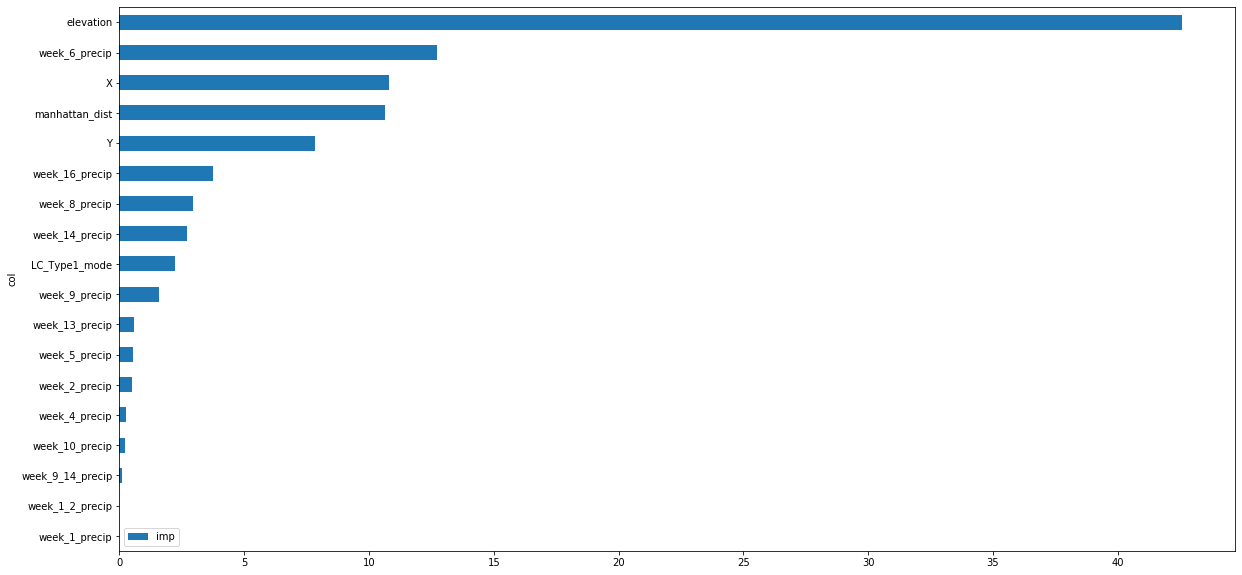

In [32]:
## Check for the feature importance 
fea_imp = pd.DataFrame({'imp':m2.feature_importances_, 'col': test.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
_ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
plt.savefig('catboost_feature_importance.png')